In [1]:
import sys
sys.path.append('../')
import os
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import seaborn as sns
from scipy.spatial.distance import cdist
from utils.utils import *
from utils.ccf_utils import *
from scipy import stats, spatial
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralClustering
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from scipy.signal import find_peaks

import warnings

warnings.filterwarnings("ignore")

#plt.rcParams['font.family'] = 'Arial'

def readSWC(swc_path, mode='simple'):
    n_skip = 0
    with open(swc_path, "r") as f:
        for line in f.readlines():
            line = line.strip()
            if line.startswith("#"):
                n_skip += 1
            # else:
                break
    names = ["##n", "type", "x", "y", "z", "r", "parent"]
    used_cols = [0, 1, 2, 3, 4, 5, 6]
    if mode == 'simple':
        pass
    df = pd.read_csv(swc_path, index_col=0, skiprows=n_skip, sep=" ",
                     usecols=used_cols,
                     names=names
                     )

    return df



In [2]:
import json
with open('../../data/region2primaryRegion.json', 'r') as f:
    region2primaryRegion = json.load(f)

In [3]:
soma_feature = pd.read_csv('../../data/155k_DEN_soma_feature.csv', sep=',', index_col=0)

soma_feature

,x,y,z,source_region,source_region_withCorticalRegion
swc_id,,,,,
SEU-ALLEN_local_15257_10001_19868_8155_CCFv3.swc,11287.600,3667.825,5563.125,fiber tracts,arb
SEU-ALLEN_local_15257_10008_10862_6996_CCFv3.swc,9625.025,3764.025,9017.726,ENTm,ENTm5
SEU-ALLEN_local_15257_10012_10978_7039_CCFv3.swc,9682.675,3754.125,8985.000,ENTm,ENTm5
SEU-ALLEN_local_15257_10020_17924_8129_CCFv3.swc,11267.750,3630.950,6364.775,fiber tracts,arb
SEU-ALLEN_local_15257_10028_28224_6732_CCFv3.swc,9298.925,3983.150,2374.200,SUB,SUB
...,...,...,...,...,...
SEU-ALLEN_local_236174_7626_18076_3068_CCFv3.swc,3998.550,1907.975,5585.175,ACAd,ACAd1
SEU-ALLEN_local_236174_8122_17844_3762_CCFv3.swc,4842.475,2017.425,5512.275,ACAd,ACAd2/3
SEU-ALLEN_local_236174_8813_17916_4826_CCFv3.swc,5990.175,2143.925,5498.300,ACAv,ACAv2/3


In [4]:
den_contact = pd.read_csv('../../data/ppss_from_pacs.csv', sep=',', index_col=0)

den_contact

,Unnamed: 0,x,y,z,source_cell,target_cell,branch_level,target_region,color
0,0,6719.33,4732.66,4685.44,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,8,VAL,#acc2d9
1,1,6719.74,4733.37,4685.04,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,8,VAL,#acc2d9
2,2,6720.34,4733.72,4684.31,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,8,VAL,#acc2d9
3,3,6720.94,4734.06,4683.59,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,8,VAL,#acc2d9
4,4,6686.39,4743.11,4648.30,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,6,VAL,#acc2d9
...,...,...,...,...,...,...,...,...,...
17995300,22299324,3283.52,3644.60,8860.40,pre_18868_00465,SEU-ALLEN_local_201584_8835_21199_4542_CCFv3.swc,9,MOp,#1f77b4
17995301,22299325,3283.40,3647.35,8860.64,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4
17995302,22299326,3283.27,3646.37,8860.83,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4
17995303,22299327,3283.14,3645.40,8861.01,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4


In [5]:
soma_feature = soma_feature[soma_feature['source_region'].isin(list(den_contact['target_region'].unique()))].copy()
soma_feature

,x,y,z,source_region,source_region_withCorticalRegion
swc_id,,,,,
SEU-ALLEN_local_15257_10001_19868_8155_CCFv3.swc,11287.600,3667.825,5563.125,fiber tracts,arb
SEU-ALLEN_local_15257_10008_10862_6996_CCFv3.swc,9625.025,3764.025,9017.726,ENTm,ENTm5
SEU-ALLEN_local_15257_10012_10978_7039_CCFv3.swc,9682.675,3754.125,8985.000,ENTm,ENTm5
SEU-ALLEN_local_15257_10020_17924_8129_CCFv3.swc,11267.750,3630.950,6364.775,fiber tracts,arb
SEU-ALLEN_local_15257_10028_28224_6732_CCFv3.swc,9298.925,3983.150,2374.200,SUB,SUB
...,...,...,...,...,...
SEU-ALLEN_local_236174_7626_18076_3068_CCFv3.swc,3998.550,1907.975,5585.175,ACAd,ACAd1
SEU-ALLEN_local_236174_8122_17844_3762_CCFv3.swc,4842.475,2017.425,5512.275,ACAd,ACAd2/3
SEU-ALLEN_local_236174_8813_17916_4826_CCFv3.swc,5990.175,2143.925,5498.300,ACAv,ACAv2/3


In [6]:
soma_ct = soma_feature['source_region'].value_counts()
del soma_ct['fiber tracts']
# soma_ct = soma_ct[0:35]
soma_ct = soma_ct[soma_ct>=30]
shared_list = list(set(soma_ct.index).intersection(den_contact['target_region'].unique()))
soma_ct

source_region
CP     21802
MOB    16644
IC      6709
AN      4770
CUL     4444
       ...  
SNc       32
APN       32
CA2       31
FN        31
SMT       30
Name: count, Length: 175, dtype: int64

In [7]:
sele_region = region2primaryRegion.keys()
order_list = []

for i in sele_region:
    if i in list(soma_ct.index):
        order_list.append(i)

print(len(order_list))

173


## branch-level distribution in same source regions

In [8]:
den_contact = den_contact[den_contact['target_region'].isin(order_list)]
den_contact

,Unnamed: 0,x,y,z,source_cell,target_cell,branch_level,target_region,color
20,20,2963.27,2784.95,3914.27,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_9293_13363_2479_CCFv3.swc,8,MOs,#56ae57
21,21,2810.66,2770.75,3799.39,15257_2226_x16029_y23953,SEU-ALLEN_local_182722_11409_13793_2164_CCFv3.swc,9,MOs,#56ae57
22,22,2811.53,2770.50,3798.97,15257_2226_x16029_y23953,SEU-ALLEN_local_182722_11409_13793_2164_CCFv3.swc,9,MOs,#56ae57
23,23,2812.41,2770.25,3798.56,15257_2226_x16029_y23953,SEU-ALLEN_local_182722_11409_13793_2164_CCFv3.swc,9,MOs,#56ae57
24,24,2813.28,2770.00,3798.14,15257_2226_x16029_y23953,SEU-ALLEN_local_182722_11409_13793_2164_CCFv3.swc,9,MOs,#56ae57
...,...,...,...,...,...,...,...,...,...
17995300,22299324,3283.52,3644.60,8860.40,pre_18868_00465,SEU-ALLEN_local_201584_8835_21199_4542_CCFv3.swc,9,MOp,#1f77b4
17995301,22299325,3283.40,3647.35,8860.64,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4
17995302,22299326,3283.27,3646.37,8860.83,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4
17995303,22299327,3283.14,3645.40,8861.01,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4


In [9]:
den_contact['count'] = 1

wide_df2_ = den_contact.pivot_table(index='target_region', columns=['branch_level'], 
                        values=['count'], aggfunc='sum', fill_value=0
                       )

wide_df2_.columns.name = ''
wide_df2_.columns = [i[1] for i in wide_df2_.columns]
wide_df2_.index.name = ''
wide_df2_

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
,,,,,,,,,,,,,,,,,,,,,
AAA,144,673,853,823,829,399,335,121,55,26,...,0,0,0,0,0,0,0,0,0,0
ACAd,3665,11133,22013,31999,32171,25411,19162,12339,6836,4134,...,142,29,0,0,0,0,0,0,0,0
ACAv,3036,8519,15984,19129,19563,17962,13964,9883,5966,3474,...,198,45,84,26,22,0,0,0,0,0
ACB,35287,113875,214127,286363,289798,236846,164850,94084,49795,25866,...,1258,329,165,126,14,0,0,0,0,0
AHN,367,1803,2026,2249,1289,603,282,192,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VM,1266,4916,10949,18066,24360,25883,22083,17962,10437,5787,...,136,99,9,0,0,0,0,0,0,0
VPL,445,2387,3129,2718,3789,3710,2792,2853,1707,856,...,87,9,0,0,0,0,0,0,0,0
VPM,1638,5430,6753,7372,8506,7042,6135,4801,3161,1427,...,50,49,8,4,0,0,0,0,0,0


In [10]:
wide_df2 = wide_df2_.copy()

for i in wide_df2.index:
    wide_df2.loc[i, :] = wide_df2.loc[i, :] / soma_ct[i]
wide_df2 = (wide_df2.T / wide_df2.sum(axis=1)).T

wide_df2

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
,,,,,,,,,,,,,,,,,,,,,
AAA,0.033279,0.155535,0.197134,0.190201,0.191588,0.092212,0.077421,0.027964,0.012711,0.006009,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ACAd,0.021269,0.064607,0.127745,0.185695,0.186693,0.147464,0.111200,0.071605,0.039670,0.023990,...,0.000824,0.000168,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ACAv,0.025161,0.070602,0.132469,0.158534,0.162131,0.148862,0.115728,0.081906,0.049444,0.028791,...,0.001641,0.000373,0.000696,0.000215,0.000182,0.0,0.0,0.0,0.0,0.0
ACB,0.022992,0.074198,0.139520,0.186587,0.188825,0.154323,0.107412,0.061303,0.032445,0.016854,...,0.000820,0.000214,0.000108,0.000082,0.000009,0.0,0.0,0.0,0.0,0.0
AHN,0.041652,0.204631,0.229940,0.255249,0.146294,0.068437,0.032005,0.021791,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VM,0.008595,0.033374,0.074331,0.122648,0.165377,0.175716,0.149919,0.121942,0.070855,0.039287,...,0.000923,0.000672,0.000061,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
VPL,0.017707,0.094979,0.124503,0.108149,0.150764,0.147621,0.111093,0.113521,0.067921,0.034060,...,0.003462,0.000358,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
VPM,0.030413,0.100821,0.125385,0.136878,0.157934,0.130751,0.113911,0.089142,0.058691,0.026496,...,0.000928,0.000910,0.000149,0.000074,0.000000,0.0,0.0,0.0,0.0,0.0


In [11]:
for i in range(1, max(wide_df2.columns)+1):
    if i not in list(wide_df2.columns):
        wide_df2[i] = 0

wide_df2 = wide_df2.loc[order_list, list(range(1, 11))]
wide_df2

,1,2,3,4,5,6,7,8,9,10
,,,,,,,,,,
FRP,0.017579,0.066266,0.129408,0.176378,0.191863,0.134970,0.097202,0.091502,0.046592,0.031210
MOp,0.013420,0.053104,0.105042,0.146689,0.167472,0.155730,0.128246,0.088982,0.057479,0.037851
MOs,0.015382,0.055973,0.105977,0.153184,0.175591,0.156832,0.125408,0.083586,0.052981,0.032014
SSp-n,0.016361,0.062857,0.112946,0.168661,0.165004,0.150396,0.119298,0.087626,0.058388,0.028318
SSp-bfd,0.018052,0.064102,0.120884,0.161387,0.174844,0.150261,0.116358,0.080523,0.053834,0.028088
...,...,...,...,...,...,...,...,...,...,...
SIM,0.010309,0.319588,0.144330,0.051546,0.113402,0.195876,0.020619,0.082474,0.061856,0.000000
AN,0.200000,0.356522,0.217391,0.139130,0.086957,0.000000,0.000000,0.000000,0.000000,0.000000
COPY,0.000000,0.000000,0.000000,0.666667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000


In [12]:
wide_df2.to_csv("./region_branch_order_distribution.csv")

In [13]:
# branch_peak = []
# for i in wide_df2.index:
#     p, _ = find_peaks(wide_df2.loc[i], plateau_size=1)
#     branch_peak.append(p)

# branch_peak

branch_peak = wide_df2.values.argmax(axis=1)+1
branch_peak

array([5, 5, 5, 4, 5, 6, 5, 6, 4, 5, 5, 5, 5, 6, 5, 4, 4, 4, 5, 5, 5, 4,
       4, 4, 4, 5, 5, 5, 4, 4, 6, 4, 5, 4, 5, 5, 5, 5, 5, 5, 3, 4, 4, 3,
       3, 4, 4, 4, 4, 4, 3, 5, 4, 4, 4, 5, 4, 4, 5, 4, 4, 3, 4, 4, 4, 4,
       3, 5, 5, 4, 4, 4, 4, 5, 5, 5, 4, 5, 5, 5, 4, 4, 3, 4, 3, 4, 4, 4,
       4, 4, 5, 5, 3, 6, 5, 5, 2, 5, 6, 7, 5, 6, 6, 5, 5, 6, 5, 4, 4, 6,
       3, 2, 3, 2, 4, 4, 5, 2, 3, 3, 4, 5, 4, 6, 4, 4, 4, 4, 3, 3, 3, 4,
       5, 4, 4, 4, 3, 2, 4, 3, 4, 3, 4, 2, 3, 5, 3, 5, 3, 3, 2, 2, 3, 2,
       5, 3, 3, 2, 2, 3, 5, 3, 3, 4, 3, 2, 3, 2, 2, 2, 4, 2, 4],
      dtype=int64)

In [14]:
wide_df2 = (wide_df2 - wide_df2.mean(axis=0)) / wide_df2.std(axis=0)
wide_df2

,1,2,3,4,5,6,7,8,9,10
,,,,,,,,,,
FRP,-0.683141,-0.570400,-0.513888,-0.149753,0.370660,0.334214,0.534550,1.274714,0.839875,0.963431
MOp,-0.806710,-0.676841,-0.803616,-0.546624,-0.006283,0.746010,1.252889,1.201893,1.302015,1.347877
MOs,-0.748427,-0.653642,-0.792501,-0.459792,0.119182,0.767871,1.187228,1.045962,1.111065,1.009980
SSp-n,-0.719344,-0.597969,-0.709636,-0.252904,-0.044429,0.640203,1.045827,1.162690,1.340594,0.795969
SSp-bfd,-0.669107,-0.587900,-0.615246,-0.350142,0.107650,0.637531,0.977800,0.957431,1.147289,0.782685
...,...,...,...,...,...,...,...,...,...,...
SIM,-0.899127,1.478255,-0.336449,-1.818450,-0.841910,1.542342,-1.237513,1.013831,1.487785,-0.843377
AN,4.736331,1.776947,0.532322,-0.647660,-1.250613,-2.343028,-1.714607,-1.369458,-1.137902,-0.843377
COPY,-1.205401,-1.106305,-2.052670,6.404241,2.557019,-2.343028,-1.714607,-1.369458,-1.137902,-0.843377


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from umap import UMAP

In [16]:
x_umap = UMAP(n_neighbors=10, 
                  n_components=2, 
                  metric='cosine',
                  min_dist=0.5, spread=1,
                  random_state=8
                 ).fit_transform(wide_df2.values)

In [17]:
primary_region_list = []

for i in wide_df2.index:
    primary_region_list.append(region2primaryRegion[i])

In [18]:
plot_df = pd.DataFrame({'x_umap0': x_umap[:, 0],
                         'x_umap1': x_umap[:, 1],
                         'color': primary_region_list,
                         'region': wide_df2.index,
                         'branch_peak': branch_peak,
                           })

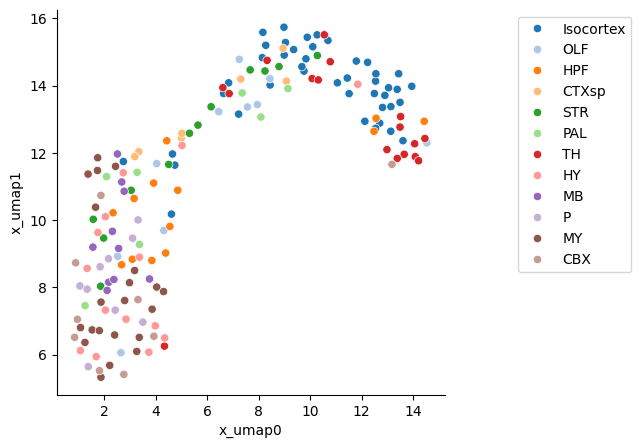

In [19]:
f, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(plot_df, x='x_umap0', y='x_umap1', 
                hue='color', palette='tab20', )
# plt.xlim([-9, 9])
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig('umap scatter.png', dpi=600, bbox_inches='tight')
plt.savefig('./umap_scatter.svg', bbox_inches='tight')

In [20]:
plot_df

,x_umap0,x_umap1,color,region,branch_peak
0,13.132565,13.376699,Isocortex,FRP,5
1,12.698297,12.883707,Isocortex,MOp,5
2,12.491214,13.763953,Isocortex,MOs,5
3,13.375913,13.888956,Isocortex,SSp-n,4
4,13.040270,13.936535,Isocortex,SSp-bfd,5
...,...,...,...,...,...
168,2.766894,5.414435,CBX,SIM,2
169,3.933227,6.549722,CBX,AN,2
170,1.877823,10.735568,CBX,COPY,4
171,13.173437,11.658637,CBX,PFL,2


In [21]:
plot_df['branch_peak2'] = 'unk'
for k,i in enumerate(plot_df.index):
    tmp_sig = np.max(branch_peak[k])
    if tmp_sig <=3:
        plot_df.loc[i, 'branch_peak2'] = 'low'
    elif tmp_sig <=5:
        plot_df.loc[i, 'branch_peak2'] = 'mid'
    else:
        plot_df.loc[i, 'branch_peak2'] = 'high'

plot_df.to_csv('./ppss_region_umap.csv', index=1)

In [22]:
plot_df

,x_umap0,x_umap1,color,region,branch_peak,branch_peak2
0,13.132565,13.376699,Isocortex,FRP,5,mid
1,12.698297,12.883707,Isocortex,MOp,5,mid
2,12.491214,13.763953,Isocortex,MOs,5,mid
3,13.375913,13.888956,Isocortex,SSp-n,4,mid
4,13.040270,13.936535,Isocortex,SSp-bfd,5,mid
...,...,...,...,...,...,...
168,2.766894,5.414435,CBX,SIM,2,low
169,3.933227,6.549722,CBX,AN,2,low
170,1.877823,10.735568,CBX,COPY,4,mid
171,13.173437,11.658637,CBX,PFL,2,low


In [23]:
x_pca = PCA(0.9).fit_transform(wide_df2.values)


In [24]:
x_pca.shape

(173, 5)

<Axes: >

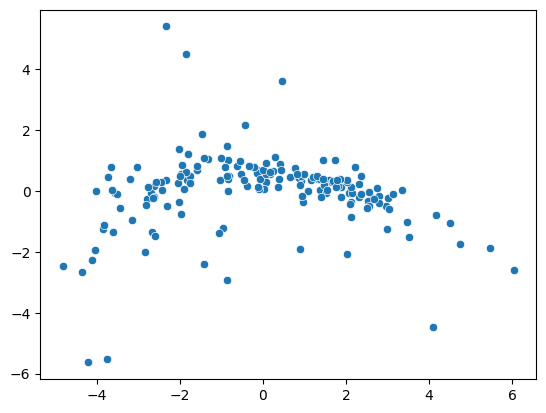

In [25]:
sns.scatterplot(x=x_pca[:,0], y=x_pca[:,1])

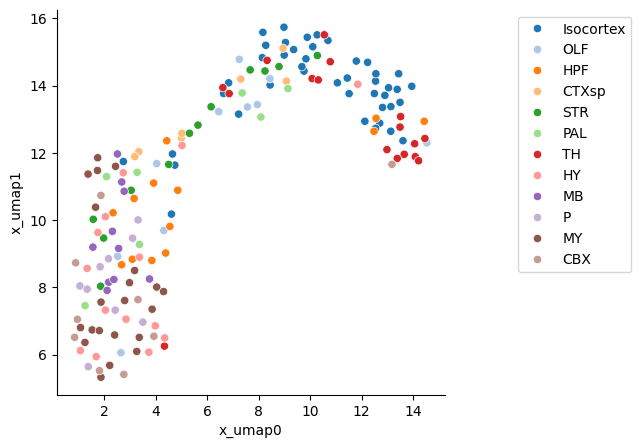

In [26]:
f, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(plot_df, x='x_umap0', y='x_umap1', 
                hue='color', palette='tab20', )
# plt.xlim([-9, 9])
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


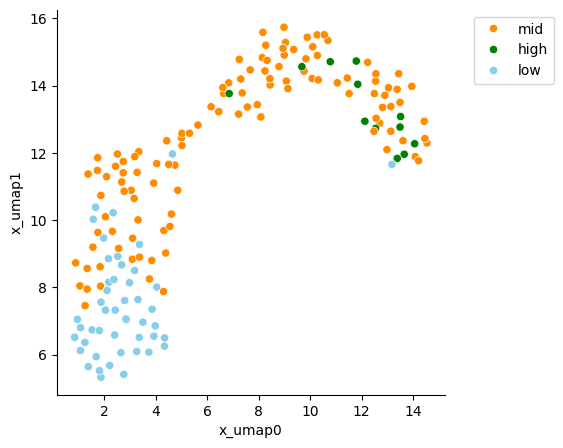

In [27]:
f, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(plot_df, x='x_umap0', y='x_umap1', 
                hue='branch_peak2', palette=['darkorange', 'green', 'skyblue'], )
# plt.xlim([-9, 9])
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('./umap_scatter_branch_peak_human.svg', bbox_inches='tight')

In [28]:
gpt_labels = pd.read_csv('../figure2/region_branch_order_distribution_classified.csv', index_col=0)
gpt_labels

,1,2,3,4,5,6,7,8,9,10,Classification
Unnamed: 0,,,,,,,,,,,
FRP,0.017579,0.066266,0.129408,0.176378,0.191863,0.134970,0.097202,0.091502,0.046592,0.031210,Intermediate-preferring
MOp,0.013420,0.053104,0.105042,0.146689,0.167472,0.155730,0.128246,0.088982,0.057479,0.037851,Distal-preferring
MOs,0.015382,0.055973,0.105977,0.153184,0.175591,0.156832,0.125408,0.083586,0.052981,0.032014,Distal-preferring
SSp-n,0.016361,0.062857,0.112946,0.168661,0.165004,0.150396,0.119298,0.087626,0.058388,0.028318,Intermediate-preferring
SSp-bfd,0.018052,0.064102,0.120884,0.161387,0.174844,0.150261,0.116358,0.080523,0.053834,0.028088,Intermediate-preferring
...,...,...,...,...,...,...,...,...,...,...,...
SIM,0.010309,0.319588,0.144330,0.051546,0.113402,0.195876,0.020619,0.082474,0.061856,0.000000,Proximal-biased
AN,0.200000,0.356522,0.217391,0.139130,0.086957,0.000000,0.000000,0.000000,0.000000,0.000000,Proximal-biased
COPY,0.000000,0.000000,0.000000,0.666667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,Intermediate-preferring


In [29]:
plot_df['gpt_label'] = 'unk'

for i in plot_df.index:
    cur_region = plot_df.loc[i, 'region']
    plot_df.loc[i, 'gpt_label'] = gpt_labels.loc[cur_region, 'Classification'].split('-')[0]

plot_df

,x_umap0,x_umap1,color,region,branch_peak,branch_peak2,gpt_label
0,13.132565,13.376699,Isocortex,FRP,5,mid,Intermediate
1,12.698297,12.883707,Isocortex,MOp,5,mid,Distal
2,12.491214,13.763953,Isocortex,MOs,5,mid,Distal
3,13.375913,13.888956,Isocortex,SSp-n,4,mid,Intermediate
4,13.040270,13.936535,Isocortex,SSp-bfd,5,mid,Intermediate
...,...,...,...,...,...,...,...
168,2.766894,5.414435,CBX,SIM,2,low,Proximal
169,3.933227,6.549722,CBX,AN,2,low,Proximal
170,1.877823,10.735568,CBX,COPY,4,mid,Intermediate
171,13.173437,11.658637,CBX,PFL,2,low,Distal


In [31]:
plot_df_ = plot_df.copy()
plot_df_ = plot_df_[['region', 'branch_peak2', 'gpt_label']]

plot_df_.rename(columns={'branch_peak2': 'human_annotation'}, inplace=True)
plot_df.to_csv('../figure6/update_stable4.csv', sep=',')

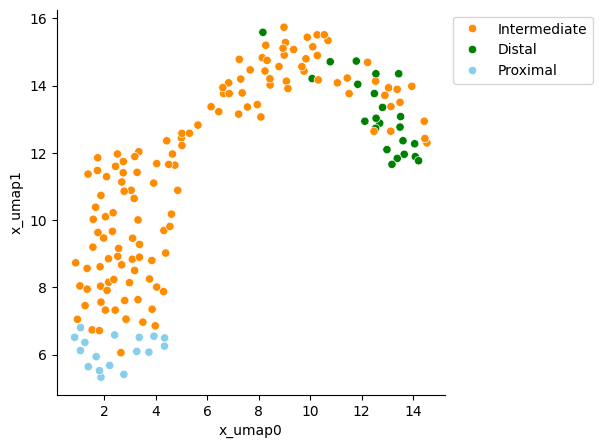

In [30]:
f, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(plot_df, x='x_umap0', y='x_umap1', 
                hue='gpt_label', palette=['darkorange', 'green', 'skyblue'], )
# plt.xlim([-9, 9])
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('./gpt_label.svg', bbox_inches='tight')